### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy import optimize
import subprocess

from astropy.coordinates import SkyCoord
from lstchain.io.config  import get_standard_config
from ctapipe.io          import read_table
import tables

# Other auxiliar scripts
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux
import geometry as geom
import lstpipeline

import logging
logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

### Configuration and parameters

In [2]:
""" Source name in order to just complete the results file, and
in order to improve run organization."""
source_name = "crab"

""" Fit parameters
Chosen limits in intensity (p.e.) for applying the fit i.e. the
power law will be fitted only with the points within this range."""
limits_intensity = [316, 562]
""" For the positive scaling cases (most of them), we need to have a lower 
limit in intensity. Thi slimit is used for the subset of events that are 
scaled just to find which is the scaling value. We use a very low limit by
default 60 p.e. compared to the lower limit of the fit 316 p.e. because in 
the worst cases we will have a very non-linear scaling that will displace 
significantly the events intensities."""
limits_intensity_extended = 60

""" Power law parameters for the reference
All these parameters are taken from a common analysis of the full dataset
Where the period of end of 2022 and start 2023 is taken as reference for good 
runs. Then we take as reference the mean power law parameters in that period.
p0 is the normalization factor and p1 is the slope."""
ref_p0 =  1.74 
ref_p1 = -2.23

""" Threshold in statistics for the last subrun
The limit in number of events after cleaning that we need to consider the last
subrun has enough statistics to perform the analysis over it. Otherwise the 
values of the scaling that will be applied to this last rubrun are the same 
that are applied to the last last subrun."""
statistics_threshold = 10000

""" Parameters for the empyrical fits for Zenith Distance corrections
Are simply two 2 degree polynomials for each variable of the power law."""
p0a, p0b, p0c = -0.44751321, 3.62502037, -1.43611437
p1a, p1b, p1c = -2.89253919, 0.99443581, -0.34013068

# Standard paths for data in the IT cluster ---------
root_dl1 = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
root_rfs = "/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod/"
root_mcs = "/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/"

# Root path of this script
root = os.getcwd() + "/"
# Path to store the configuration file we are going to use
config_file = root + "config/standard_config.json"
# Path to store objects
root_objects = root + f"objects/"
# Data main directory
root_data = root + f"../../data/cherenkov_transparency_corrections/{source_name}/"
# Sub-dl1 objects directory
root_sub_dl1 = root_objects + "sub_dl1/"
# Directory for the results of the fit of each run
root_results = root_objects + "results_fits/"
root_final_results = root_objects + "final_results_fits/"
# Slurm output folder
root_slurm = root + "objects/output_slurm"
# Configuration file for the job launching
file_job_config = root_objects + "config/job_config_runs.txt"

def configure_lstchain():
    """Creates a file of standard configuration for the lstchain analysis. 
    It can be changed inside this function"""
    dict_config = get_standard_config()
    # We select the heuristic flatfield option in the standard configuration
    dict_config["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True
    with open(config_file, "w") as json_file:
        json.dump(dict_config, json_file)

### Input parameters

In [3]:
""" The run number that we are interested in apply the corrections.
The process is done run-wise, so the input will be an individual run."""
input_str = "3093_0_25"
simulate_data = True

### First initial variables computed

In [4]:
# Extracting the run number from the input string
run_number   = int(input_str.split("_")[0])
first_last_srun = [int(s) for s in input_str.split("_")[1:]]
if len(first_last_srun) == 1:
    srun_numbers = np.array(first_last_srun)
else:
    srun_numbers = np.arange(first_last_srun[0], first_last_srun[1] + 1)

""" Empty dictionary to store all the results of one run."""
dict_results_empty = { 
    "run": run_number, "filenames": {}, "statistics": {}, "flag_error" : {},
    "scaled" :           {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "p0":                {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_p0":          {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "p1":                {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_p1":          {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "chi2":              {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "pvalue":            {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "light_yield":       {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_light_yield": {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "scaling":           {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_scaling":     {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "scaling_percent":       {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_scaling_percent": {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "final_scaling": {}, "final_scaling_interpolated": {}, "interpolation" : {},
}

# Create the paths that do not exist
for path in [os.path.dirname(config_file), root_data, root_objects, root_results, root_final_results, root_sub_dl1]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Creating and storing a configuration file for lstchain processes
configure_lstchain()

### Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [5]:
%%time
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
}

# We create a empty dictionary to store all the information needed inside
dict_dchecks = {}
for run in [run_number]:
    dict_dchecks[run] = {
        "run_num" : run,
    }
# Then we add the paths to the files and the datachecks
dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1)
dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1, dchecking=True)


Adding dl1  data to dictionary (Run 3093)...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary (Run 3093)...
...Finished adding dl1 data to dictionary


CPU times: user 12.2 s, sys: 6.88 s, total: 19.1 s
Wall time: 30 s


#### Then we read the observations information and also the selected nodes for MC and RFs and we add it to the DICT

In [6]:
dcheck_zd, dcheck_az = [], []
dcheck_tstart, dcheck_telapsed = [], []

for srun in range(len(dict_dchecks[run_number]["dchecks"]["srunwise"])):
    tab_dcheck_srun = read_table(dict_dchecks[run_number]["dchecks"]["srunwise"][srun], "/dl1datacheck/cosmics")
    
    # reading the variables
    dcheck_zd.append(90 - np.rad2deg(tab_dcheck_srun["mean_alt_tel"]))
    dcheck_az.append(np.rad2deg(tab_dcheck_srun["mean_az_tel"]))
    
    dcheck_tstart.append(tab_dcheck_srun["dragon_time"])
    dcheck_telapsed.append(tab_dcheck_srun["elapsed_time"])

dcheck_zd = np.array(dcheck_zd)
dcheck_az = np.array(dcheck_az)
dcheck_tstart = np.array(dcheck_tstart)
dcheck_telapsed = np.array(dcheck_telapsed)

dict_dchecks[run_number]["time"] = {
    "tstart"   : dcheck_tstart[0],            # datetime object
    "telapsed" : np.sum(dcheck_telapsed),  # s
    "srunwise" : {
        "telapsed" : dcheck_telapsed,      # s      
    },
}
dict_dchecks[run_number]["pointing"] = {
    "zd" : np.mean(dcheck_zd),  # deg
    "az" : np.mean(dcheck_az),  # deg
    "srunwise" : {
        "zd" : dcheck_zd, # deg
        "az" : dcheck_az, # deg
    },
}
# then we also select the RFs and MC files looking at the nodes available
dict_dchecks, dict_nodes = lstpipeline.add_mc_and_rfs_nodes(dict_dchecks, root_rfs, root_mcs, dict_source)

### Read datacheck
#### - The binning

In [7]:
# Pivot intensity for decorrelation
ref_intensity = (limits_intensity[0] * limits_intensity[1]) ** 0.5
logger.info(f"The intensity in the middle of the intensity range is {ref_intensity:.1f} p.e.")

########################################################
# Reading the binning from the datacheck ---------------
# Opening the corresponding datacheck
fname_dcheck = dict_dchecks[run_number]["dchecks"]["runwise"]
tab_dcheck_run = tables.open_file(fname_dcheck)

# Read the binning from the datacheck of the first subrun
dcheck_intensity_binning = np.array(tab_dcheck_run.root.dl1datacheck.histogram_binning.col("hist_intensity")[0])
# Calculating the logarithmic center of each bin
dcheck_intensity_binning_centers = (dcheck_intensity_binning[:-1] * dcheck_intensity_binning[1:]) ** 0.5
# Calculating the width of each bin
dcheck_intensity_binning_widths = np.diff(dcheck_intensity_binning)
tab_dcheck_run.close()

# Mask for the fitting region in the fits
mask_dcheck_bins_fit = (
    (dcheck_intensity_binning_centers >= limits_intensity[0]) &
    (dcheck_intensity_binning_centers <= limits_intensity[1])
)

The intensity in the middle of the intensity range is 421.4 p.e.


#### - The intensity data from the datacheck

In [8]:
##########################################################
# Reading the histogram from the datacheck ---------------
# Opening the corresponding datacheck
dcheck_hist_intensities = []
for fname_dcheck_srun in dict_dchecks[run_number]["dchecks"]["srunwise"]:
    tab_dcheck_srun = tables.open_file(fname_dcheck_srun)
    dcheck_hist_intensities.append(np.array(tab_dcheck_srun.root.dl1datacheck.cosmics.col("hist_intensity")))
    tab_dcheck_srun.close()

# Converting from counts to rate per intensity unit (non-binning dependent quantity)
dcheck_rates       = [] # Array of histogram of rates for each subrun
dcheck_delta_rates = [] # The statistical error
for srun, dcheck_hist_intensity in enumerate(dcheck_hist_intensities):

    effective_time_srun = dict_dchecks[run_number]["time"]["srunwise"]["telapsed"][srun]
    
    dcheck_rates.append(              dcheck_hist_intensity  / effective_time_srun / dcheck_intensity_binning_widths)

    dcheck_delta_rates.append(np.sqrt(dcheck_hist_intensity) / effective_time_srun / dcheck_intensity_binning_widths)

### Correction factors

In [9]:
corr_factor_p0 = geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(dict_dchecks[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
corr_factor_p1 = geom.pol2(1, p1a, p1b, p1c) - geom.pol2(np.cos(np.deg2rad(dict_dchecks[run_number]["pointing"]["zd"])), p1a, p1b, p1c)

# Zenith correction of the reference (putting the reference in the zenith of the determined subrun)
corr_ref_p0 = ref_p0 / corr_factor_p0
corr_ref_p1 = ref_p1 - corr_factor_p1

### Function to perform all the scaling and then the reading
#### - Zenith corrections and light yield
#### - Defining scaling

In [10]:
def find_scaling(iteration_step, dict_results, other_parameters, simulated=False):
    """
    A function to perform scaling and evaluating the results. Returning everything in a updated dictionary

    Input:
    - iteration_step: (str) 
        The iteration step you are in, that can be "original" for the original data, "upper" for the upper
        limit on the scale factor, "linear" for the linear intepolation factor and "final" for the final scaling 
        and results.
        
    - dict_results: (dict)
        Dictionary with the results of the before step.
        
    - simulated: (bool)
        If instead of scaling the data, random data is generated just to fill the values. Short to run tests.

    - other_parameters (dict)
        A dictionary with all other needed parameters:
        * "srun_numbers"
        * "dict_dchecks"
        * "ref_intensity"
        * "dcheck_intensity_binning"
        * "dcheck_intensity_binning_widths"
        * "dcheck_intensity_binning_centers"
        * "mask_dcheck_bins_fit"
        * "corr_factor_p0"
        * "corr_factor_p1"
    """

    # Reading the other variables dictionary
    srun_numbers = other_parameters["srun_numbers"]
    dict_dchecks = other_parameters["dict_dchecks"]
    ref_intensity = other_parameters["ref_intensity"]
    dcheck_intensity_binning = other_parameters["dcheck_intensity_binning"]
    dcheck_intensity_binning_widths = other_parameters["dcheck_intensity_binning_widths"]
    dcheck_intensity_binning_centers = other_parameters["dcheck_intensity_binning_centers"]
    mask_dcheck_bins_fit = other_parameters["mask_dcheck_bins_fit"]
    corr_factor_p0 = other_parameters["corr_factor_p0"]
    corr_factor_p1 = other_parameters["corr_factor_p1"]
    
    # Creating a arrray of subruns looking at the datachecks and also extracting the run number
    run_number  = dict_results["run"]

    # Empty arrays to store the fit information
    data_p0, data_delta_p0 = [], []
    data_p1, data_delta_p1 = [], []
    data_chi2, data_pvalue = [], []
    
    # Processing subrun by subrun---------------------------------------------------------------
    for srun in srun_numbers:    

        # Reading dl1
        #################################################
        input_fname = dict_dchecks[run_number]["dl1a"]["srunwise"][srun]   # Input dl1a 
        data_scale_factor = dict_results["scaled"][iteration_step][srun]   # Reading the scaling factor

        # Here we do different things depending on the iteration step
        # ////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////
        # If is the first one i.e. == "original"
        # We do not run lstchain_dl1ab because the data is already scaled
        if iteration_step == "original":
            data_output_fname = input_fname

        # ////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////
        # If is the second or third: "upper" or "linear"
        # We perform lstchain_dl1ab but over a subset of the data only to keep it shorter
        elif iteration_step in ["upper", "linear"]:

            # Temporal dl1 file that will be overwritten in the next iteration / subrun
            data_output_fname = root_sub_dl1 + f"tmp_dl1_srunwise_run{run_number}_srun{srun}_{iteration_step}_scaled.h5" 

            logger.info(f"\nProcessing subrun {srun}")

            # If scale is greater than 1 we select a range lower than the upper one
            # otherwise we select a range higher than the upper one
            if data_scale_factor > 1:
                dl1_selected_range = f"{limits_intensity_extended:.2f},{limits_intensity[1]:.2f}"
            else:
                dl1_selected_range = f"{limits_intensity[0]:.2f},inf"

            if not simulated:
                logger.info(f"Running lstchain_dl1ab... scale: {data_scale_factor:.2f}")
                # If the file already exists we delete it
                if os.path.exists(data_output_fname):
                    os.remove(data_output_fname)
            
                command = f"lstchain_dl1ab --input-file {input_fname} --output-file {data_output_fname} --config {config_file}"
                command = command + f" --no-image --light-scaling {data_scale_factor} --intensity-range {dl1_selected_range}"
                logger.info(command)

                # We add an exception because sometimes can fail...
                ntries = 3
                while ntries > 0:
                    try:
                        ntries = ntries - 1
                        subprocess.run(command, shell=True)
                    except Exception as e:
                        logger.error(f"FLAG HERE! Failed to run {command} with error: {repr(e)}")
        # ////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////
        # If is the last step i.e. "final"
        # The lstchain_dl1ab script is run over all thedataset to generate the final file
        elif iteration_step == "final":

            data_output_fname = root_data + f"dl1_scaled/{run_number:05}/" + os.path.basename(dict_dchecks[run_number]["dl1a"]["srunwise"][srun])
            logger.info(f"\nProcessing subrun {srun}")

            if not simulated:
                logger.info(f"Running lstchain_dl1ab... scale: {data_scale_factor:.2f}")
                # If the file already exists we delete it
                if os.path.exists(data_output_fname):
                    os.remove(data_output_fname)
            
                command = f"lstchain_dl1ab --input-file {input_fname} --output-file {data_output_fname} --config {config_file}"
                command = command + f" --no-image --light-scaling {data_scale_factor}"
                logger.info(command)
                
                # We add an exception because sometimes can fail...
                ntries = 3
                while ntries > 0:
                    try:
                        ntries = ntries - 1
                        subprocess.run(command, shell=True)
                    except Exception as e:
                        logger.error(f"FLAG HERE! Failed to run {command} with error: {repr(e)}")
    
            # We store this info also in the dictionary in the final case
            dict_results["filenames"][srun] = data_output_fname

        #################################################################
        # Reading the dl1 file
        #################################################################
        if not simulated:
            table_data = tables.open_file(data_output_fname)
            data_counts_intensity, _ = np.histogram(
                table_data.root.dl1.event.telescope.parameters.LST_LSTCam.col("intensity"), 
                bins=dcheck_intensity_binning
            )
            table_data.close()
        else:
            # Simulated example data where we add random noise
            simdata = [0,0,2,6,12,23,20,15,25,56,105,214,441,694,933,1244,1429,1582,1597,1545,1498,1479,1484,1364,1296,1290,
                       1228,1089,1004,834,732,665,613,529,411,426,307,266,201,191,186,150,114,121,93,87,62,60,38,39,27,31,33,
                       26,22,24,20,13,11,11,8,6,5,8,4,4,5,4,3,1,1,2,1,0,1,1,1,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            simdata = np.array(simdata)
            if iteration_step == "original":
                data_counts_intensity = simdata + np.random.rand(100) * 100
            elif iteration_step == "upper":
                data_counts_intensity = simdata * 0.1 + np.random.rand(100) * 10
            elif iteration_step == "linear":
                data_counts_intensity = simdata * 0.03 + np.random.rand(100) * 10
            elif iteration_step == "final":
                data_counts_intensity = simdata * 0.06 + np.random.rand(100) * 10
        
        # Calculating the non binning dependent transformation
        effective_time_srun = dict_dchecks[run_number]["time"]["srunwise"]["telapsed"][srun]
        data_rates       = np.array(data_counts_intensity) / effective_time_srun / dcheck_intensity_binning_widths
        data_delta_rates = np.sqrt(data_counts_intensity)  / effective_time_srun / dcheck_intensity_binning_widths


        #################################################################
        # Performing the fit
        #################################################################
        # Displacing the X-coordinates to the center of the fit, in order to decorrelate the fit
        x_fit = dcheck_intensity_binning_centers[mask_dcheck_bins_fit] / ref_intensity
        y_fit = data_rates[mask_dcheck_bins_fit]
        yerr_fit = data_delta_rates[mask_dcheck_bins_fit]
        
        # Trying for the cases where the data is bad and the fit returns an error
        try:
            params, pcov, info, _, _ = curve_fit(
                f     = geom.powerlaw,
                xdata = x_fit,
                ydata = y_fit,
                sigma = yerr_fit,
                p0    = [ref_p0, ref_p1],
                full_output = True,
            )
        
            srun_p0, srun_p1  = params
            srun_delta_p0 = np.sqrt(pcov[0, 0])
            srun_delta_p1 = np.sqrt(pcov[1, 1])
            srun_chi2     = np.sum(info["fvec"] ** 2)
            srun_pvalue   = 1 - chi2.cdf(srun_chi2, sum(mask_dcheck_bins_fit))
            dict_results["flag_error"][srun] = False

        # If the fit is not successful we return nan values
        except RuntimeError:
            logger.error(f"For run {run_number} and subrun {srun}, the fit failed due to RuntimeError.")
            srun_p0, srun_p1  = np.nan, np.nan
            srun_delta_p0 = np.nan
            srun_delta_p1 = np.nan
            srun_chi2     = np.nan
            srun_pvalue   = np.nan
            dict_results["flag_error"][srun] = True
            
        dict_results["chi2"][iteration_step][srun]   = srun_chi2
        dict_results["pvalue"][iteration_step][srun] = srun_pvalue
        dict_results["scaled"][iteration_step][srun] = data_scale_factor
    
        data_p0.append(srun_p0)
        data_p1.append(srun_p1)
        data_delta_p0.append(srun_delta_p0)
        data_delta_p1.append(srun_delta_p1)
        data_chi2.append(srun_chi2)
        data_pvalue.append(srun_pvalue)
    
    # Convert to numpy arrays
    data_p0       = np.array(data_p0)
    data_p1       = np.array(data_p1)
    data_delta_p0 = np.array(data_delta_p0)
    data_delta_p1 = np.array(data_delta_p1)
    data_chi2     = np.array(data_chi2)
    data_pvalue   = np.array(data_pvalue)
  
    # Zenith corrections to the parameters
    #########################################################
    data_corr_p0 = data_p0 * corr_factor_p0
    data_corr_p1 = data_p1 + corr_factor_p1
    
    data_corr_delta_p0 = data_delta_p0 * corr_factor_p0
    data_corr_delta_p1 = data_delta_p1
    
    # Calculating the needed light yield  
    data_light_yield, data_delta_light_yield = geom.calc_light_yield(
        p0_fit = data_corr_p0,
        p1_fit = data_corr_p1, 
        sigma_p0_fit = data_corr_delta_p0, 
        sigma_p1_fit = data_corr_delta_p1, 
        p0_ref = ref_p0,
    )
    # Scalings to apply
    data_scaling       = 1 / data_light_yield
    data_delta_scaling = 1 / data_light_yield ** 4 * data_delta_light_yield
    # The scaling in percentage
    data_scaling_percent       = (data_scaling - 1) * 100
    data_delta_scaling_percent = data_delta_scaling * 100
    
    # Adding to dictionary
    for i, srun in enumerate(srun_numbers):
        dict_results["p0"][iteration_step][srun]       = data_corr_p0[i]
        dict_results["delta_p0"][iteration_step][srun] = data_corr_delta_p0[i]
        dict_results["p1"][iteration_step][srun]       = data_corr_p1[i]
        dict_results["delta_p1"][iteration_step][srun] = data_corr_delta_p1[i]
        
        dict_results["light_yield"][iteration_step][srun]       = data_light_yield[i]
        dict_results["delta_light_yield"][iteration_step][srun] = data_delta_light_yield[i]
        dict_results["scaling"][iteration_step][srun]           = data_scaling[i]
        dict_results["delta_scaling"][iteration_step][srun]     = data_delta_scaling[i]
        dict_results["scaling_percent"][iteration_step][srun]   = data_scaling_percent[i]
        dict_results["delta_scaling_percent"][iteration_step][srun] = data_delta_scaling_percent[i]

    return dict_results

other_parameters = {
    "srun_numbers" : srun_numbers,
    "dict_dchecks" : dict_dchecks,
    "ref_intensity" : ref_intensity,
    "dcheck_intensity_binning" : dcheck_intensity_binning,
    "dcheck_intensity_binning_widths" : dcheck_intensity_binning_widths,
    "dcheck_intensity_binning_centers" : dcheck_intensity_binning_centers,
    "mask_dcheck_bins_fit" : mask_dcheck_bins_fit,
    "corr_factor_p0" : corr_factor_p0,
    "corr_factor_p1" : corr_factor_p1,
}

### Applying the function over the original data

In [11]:
%%time
# The main results dictionary
dict_results = dict_results_empty.copy()
# First filling the dictionary with ones in the scaled values
# and saving the number of events stored in each subrun.
for srun in srun_numbers:
    dict_results["scaled"]["original"][srun] = 1.0
    dict_results["statistics"][srun] = int(np.sum(dcheck_hist_intensities[srun]))

# Then we read these files and perform the fits
dict_results = find_scaling(
    iteration_step="original", dict_results=dict_results, other_parameters=other_parameters, simulated=simulate_data
)

# Then filling the next step "scaled" with the calculated one
for srun in srun_numbers:
    dict_results["scaled"]["upper"][srun] = dict_results["scaling"]["original"][srun]

CPU times: user 28.3 ms, sys: 12.6 ms, total: 41 ms
Wall time: 104 ms


### Performing the first scaling for first run

In [12]:
%%time
dict_results = find_scaling(
    iteration_step="upper", dict_results=dict_results, other_parameters=other_parameters, simulated=simulate_data
)


Processing subrun 0

Processing subrun 1

Processing subrun 2

Processing subrun 3

Processing subrun 4

Processing subrun 5

Processing subrun 6

Processing subrun 7

Processing subrun 8

Processing subrun 9

Processing subrun 10

Processing subrun 11

Processing subrun 12

Processing subrun 13

Processing subrun 14

Processing subrun 15

Processing subrun 16

Processing subrun 17

Processing subrun 18

Processing subrun 19

Processing subrun 20

Processing subrun 21

Processing subrun 22

Processing subrun 23

Processing subrun 24

Processing subrun 25


CPU times: user 43.1 ms, sys: 15 ms, total: 58.1 ms
Wall time: 47.5 ms


### Performing linear interpolation to calculate the new scaling factor

In [13]:
for srun in srun_numbers:

    # Now putting all together, upper and half
    points_scaling     = np.array([1, dict_results["scaling"]["original"][srun]])
    points_light_yield = np.array([dict_results["light_yield"]["original"][srun], dict_results["light_yield"]["upper"][srun]])

    # Finding the final scaling as a line that pass trogh the two points we have
    # Then we calculate where the light yield will be 1 in linear approximation
    slope = (points_light_yield[1] - points_light_yield[0]) / (points_scaling[1] - points_scaling[0])
    intercept = points_light_yield[0] - slope * points_scaling[0]
    linear_scale_factor = 1 / slope - points_light_yield[0] / slope + points_scaling[0]

    dict_results["scaled"]["linear"][srun] = linear_scale_factor

### Applying the linear factor to the data and then re-calculating the parameters

In [14]:
%%time
dict_results = find_scaling(
    iteration_step="linear", dict_results=dict_results, other_parameters=other_parameters, simulated=simulate_data
)


Processing subrun 0

Processing subrun 1

Processing subrun 2

Processing subrun 3

Processing subrun 4

Processing subrun 5

Processing subrun 6

Processing subrun 7

Processing subrun 8

Processing subrun 9

Processing subrun 10

Processing subrun 11

Processing subrun 12

Processing subrun 13

Processing subrun 14

Processing subrun 15

Processing subrun 16

Processing subrun 17

Processing subrun 18

Processing subrun 19

Processing subrun 20

Processing subrun 21

Processing subrun 22

Processing subrun 23

Processing subrun 24

Processing subrun 25


CPU times: user 46 ms, sys: 6.34 ms, total: 52.4 ms
Wall time: 43.1 ms


### Then calculate the final light yield and scaling

1.2967510895361736 +- 7.203387957933295


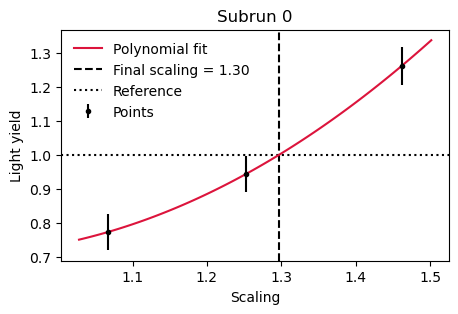

1.2113247138307646 +- 30.43025827248108


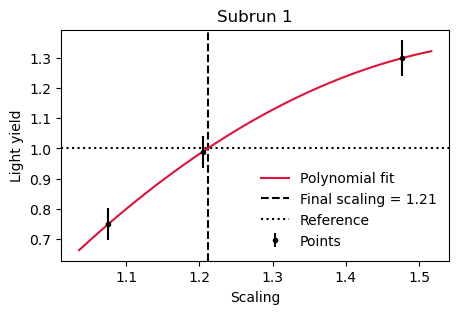

1.2852799907717147 +- 2.0525407670230456


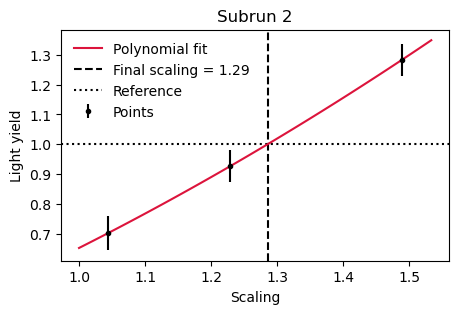

1.2686375966273167 +- 35.393311528500455


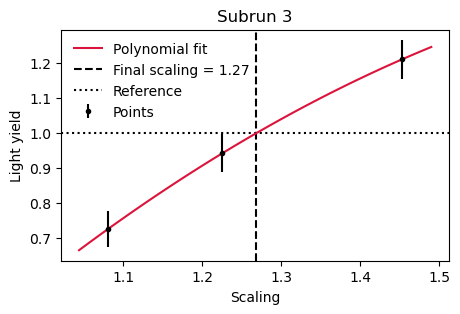

1.2235038110051821 +- 7.6972065333399575


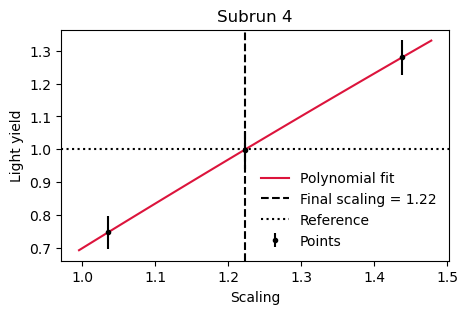

1.3174543108434835 +- 14.920490327403154


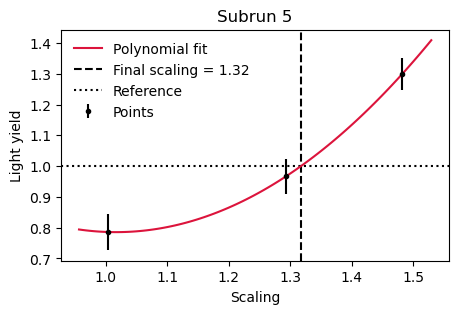

1.2674888793319532 +- 11.619334789234022


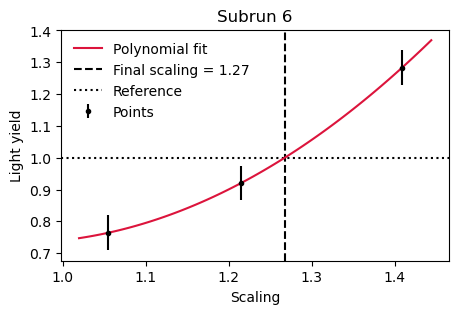

1.3191974894176708 +- 13.341576585671525


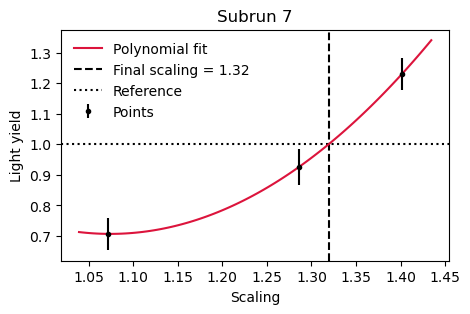

1.2895570786484407 +- 16.55593666977099


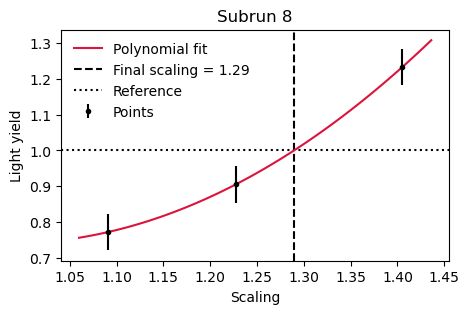

1.2641015907812818 +- 2.2027646363148845


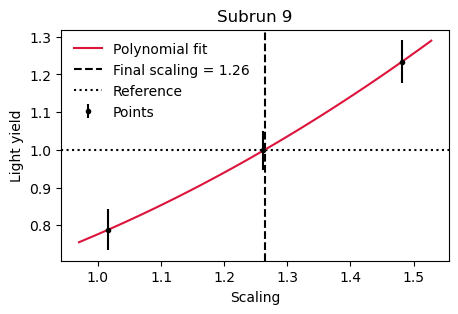

1.3332423346366076 +- 3.739966563439678


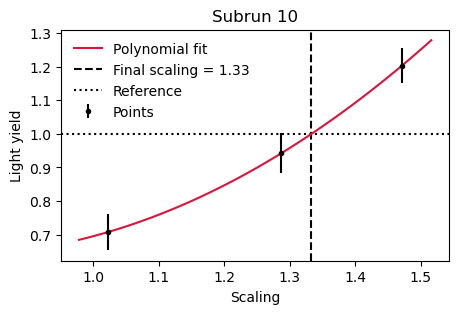

1.23303944993719 +- 22.743879740703264


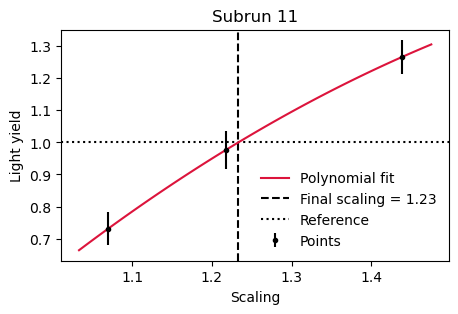

1.2980857819555127 +- 9.888045780175055


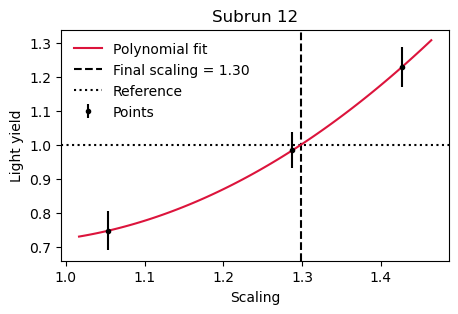

1.3243121378758134 +- 14.7459720782231


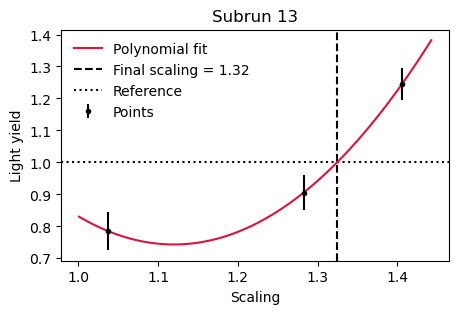

1.2628942817618527 +- 10.694727983619947


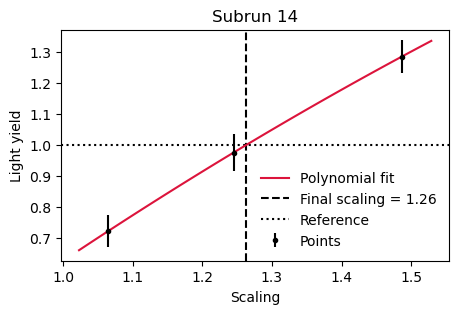

1.2561555398016193 +- 33.30885661347535


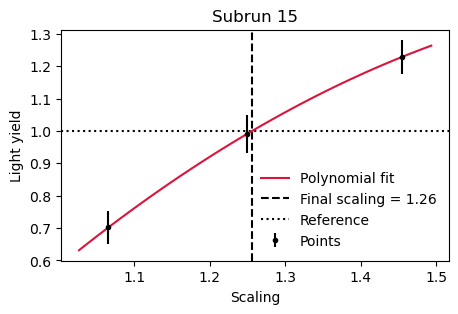

1.223453841315857 +- 67.2322639512331


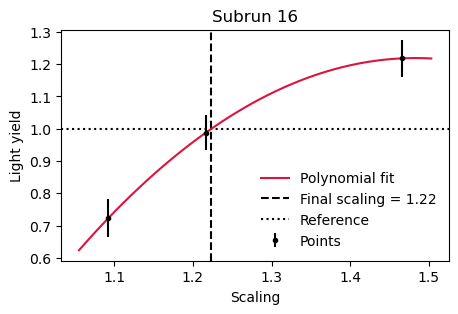

1.2455353881040239 +- 18.507476130586873


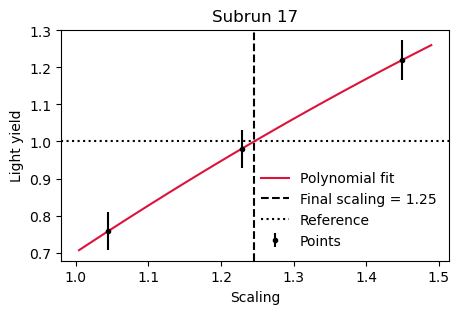

1.3227356548042537 +- 14.445312884246686


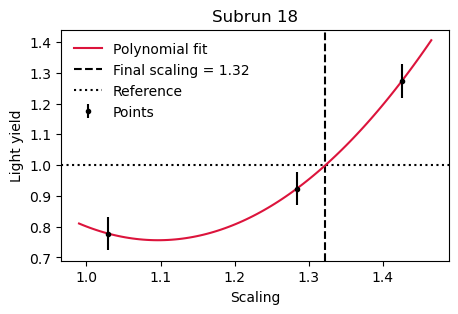

1.2296012301615824 +- 35.90603788130106


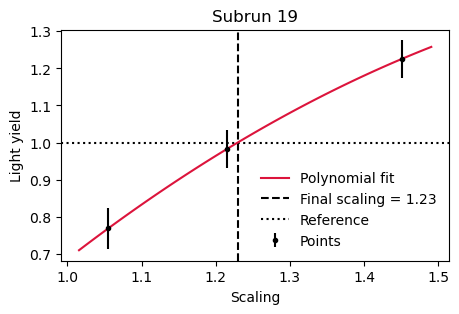

1.2906756720967167 +- 2.8820167803111234


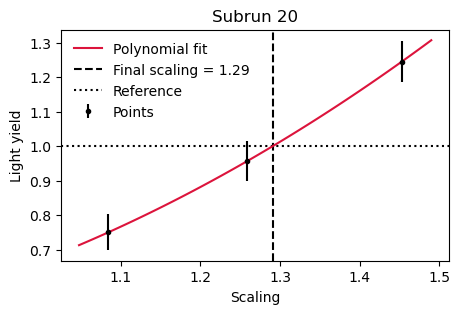

1.2558003864180696 +- 69.0702549787268


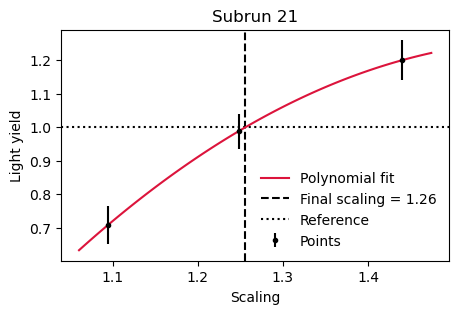

1.3024246051802368 +- 14.557690918963745


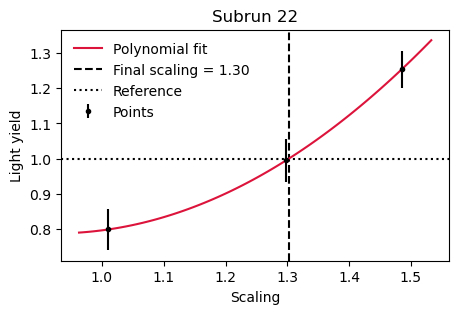

1.2558083399785611 +- 40.50286329467107


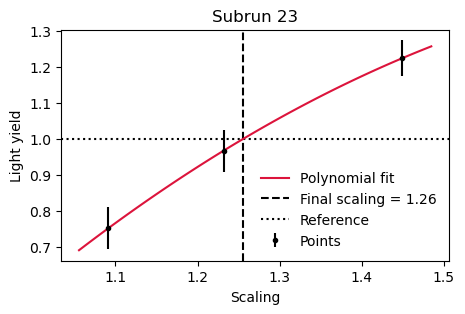

1.3130016295013849 +- 11.194589986407285


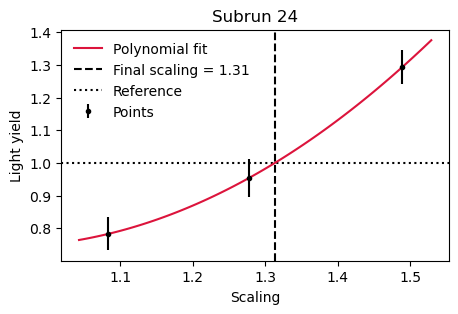

1.3324413746651083 +- 9.097599754703731


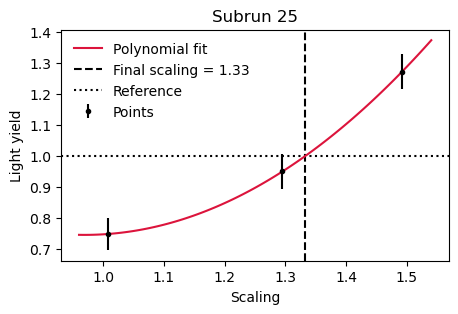

In [17]:
for srun in srun_numbers:

    # Only calculating for the cases with no flag errors:
    if not dict_results["flag_error"][srun]:

        # Now putting all together, upper and half
        points_scaling           = np.array([dict_results["scaled"][key][srun]            for key in ["original", "linear", "upper"]])
        points_light_yield       = np.array([dict_results["light_yield"][key][srun]       for key in ["original", "linear", "upper"]])
        points_delta_light_yield = np.array([dict_results["delta_light_yield"][key][srun] for key in ["original", "linear", "upper"]])
        
        if simulate_data:
            points_scaling           = np.array([1, 1.2, 1.4])       + np.random.rand(3) * 0.1
            points_light_yield       = np.array([0.7, 0.9, 1.2])     + np.random.rand(3) * 0.1
            points_delta_light_yield = np.array([0.05, 0.05, 0.05])  + np.random.rand(3) * 0.01        
            
        srun_a, srun_b, srun_c, srun_delta_a, srun_delta_b, srun_delta_c = geom.parabola_3points(
            *points_scaling, *points_light_yield, *points_delta_light_yield
        )
        
        range_avg_point = np.mean(points_scaling)
        x0, delta_x0 = geom.get_roots_pol2(
            range_avg_point, 1,*points_scaling, *points_light_yield, *points_delta_light_yield
        )

        final_scale_factor = x0
        delta_final_scale_factor = delta_x0
        
        ############################################
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        ax.errorbar(points_scaling, points_light_yield, yerr=points_delta_light_yield,
                    marker=".", color="k", label="Points", zorder=10, ls="")
        size_points = max(points_scaling) - min(points_scaling)
        sample_scaling = np.linspace(min(points_scaling) - 0.1 * size_points, max(points_scaling) + 0.1 * size_points, 100)
        ax.plot(sample_scaling, geom.pol2(sample_scaling, srun_a, srun_b, srun_c), 
                color="crimson", ls="-", label="Polynomial fit", zorder=5)
        ax.axvline(x0, color="k", ls="--", label=f"Final scaling = {final_scale_factor:.2f}")
        ax.axvspan(x0 - delta_x0, x0 + delta_x0, color="k", alpha=0.2, ls="")
        ax.axhline(1, color="k", ls=":", label="Reference")
        ax.set_xlabel("Scaling")
        ax.set_ylabel("Light yield")
        ax.legend(frameon=False)
        ax.set_title(f"Subrun {srun}")
        # plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
        plt.show()
        ############################################

    else:
        final_scale_factor = np.nan
        delta_final_scale_factor = np.nan
        
    dict_results["final_scaling"][srun] = final_scale_factor
    dict_results["delta_final_scaling"][srun] = delta_final_scale_factor

## Storing the dictionary with the information

In [ ]:
# Storing data in a pkl object
dict_fname = root_results + f"results_job_{input_str}.pkl"

# Saving the objects
with open(dict_fname, 'wb') as f:
    pickle.dump(dict_results, f, pickle.HIGHEST_PROTOCOL)
    
# # Reading the object
# with open(dict_fname, 'rb') as f:
#     dict_results = pickle.load(f)